# Sitagliptin analog generator in REINVENT

author: @fmkz___

Sitagliptin is a DPP-4 inhibitor

- [CHEMBL1422](https://www.ebi.ac.uk/chembl/compound/inspect/CHEMBL1422)
- [DrugBank](https://www.drugbank.ca/drugs/DB01261)
- [PDB:1X70](https://www.rcsb.org/structure/1x70)
- [Patent(SureChEMBL)](https://www.surechembl.org/document/WO-2003004498-A1/?query=)

In [115]:
%matplotlib inline
import sys
sys.path.append("/Users/kzfm/mishima_syk/REINVENT")
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs, Draw
from sklearn.decomposition import PCA
from sklearn.cluster import AffinityPropagation
from ggplot import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [116]:
patent_mols = []
with open("WO2003004498A1.csv") as f:
    f.readline()
    for l in f:
        smi = l.split(",")[-25] # some molecule
        smi = smi[1:-1]
        mol = Chem.MolFromSmiles(smi)
        patent_mols.append(mol)

In [117]:
pat_fps = []
for mol in patent_mols:
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2)
    arr = np.zeros((1,))
    DataStructs.ConvertToNumpyArray(fp, arr)
    pat_fps.append(arr)
pat_fps = np.array(pat_fps)

pca = PCA(n_components=2)
x = pca.fit(pat_fps).transform(pat_fps)
af = AffinityPropagation().fit(x)

d = pd.DataFrame(x)
d.columns = ["PCA1", "PCA2"]
d["labels"] = pd.Series(af.labels_)
g = ggplot(aes(x="PCA1", y="PCA2", color="labels"), data=d) + geom_point() + xlab("PCA1") + ylab("PCA2")

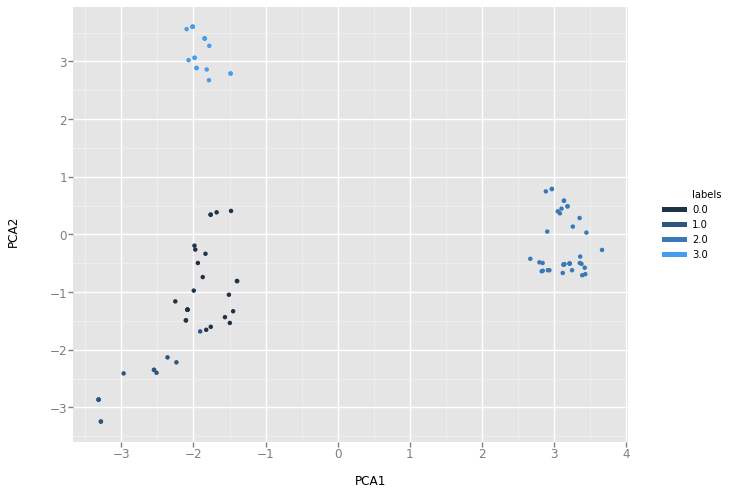

<ggplot: (-9223372036569750661)>


In [118]:
print(g)

# Training REINVENT

    ./main.py --scoring-function tanimoto --scoring-function-kwargs query_structure 'N[C@@H](CC(=O)N1CCn2c(C1)nnc2C(F)(F)F)Cc3cc(F)c(F)cc3F' --num-steps 300 --sigma 80

It took about 1hour on my laptop(MBA).

In [119]:
import torch
from model import RNN
from data_structs import Vocabulary
from utils import seq_to_smiles

In [120]:
voc = Vocabulary(init_from_file="/Users/kzfm/mishima_syk/REINVENT/data/Voc")
Agent = RNN(voc)
Agent.rnn.load_state_dict(torch.load("sitagliptin_agent/Agent.ckpt"))
seqs, agent_likelihood, entropy = Agent.sample(200)

In [121]:
smiles = seq_to_smiles(seqs, voc)

In [122]:
fps = []
mols = []
for smi in smiles:
    mol = Chem.MolFromSmiles(smi)
    if mol is not None:
        mols.append(mol)
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2)
        arr = np.zeros((1,))
        DataStructs.ConvertToNumpyArray(fp, arr)
        fps.append(arr)
fps = np.array(fps)

pca = PCA(n_components=2)
x = pca.fit(fps).transform(fps)
af = AffinityPropagation().fit(x)

d = pd.DataFrame(x)
d.columns = ["PCA1", "PCA2"]
d["labels"] = pd.Series(af.labels_)
g = ggplot(aes(x="PCA1", y="PCA2", color="labels"), data=d) + geom_point() + xlab("PCA1") + ylab("PCA2")

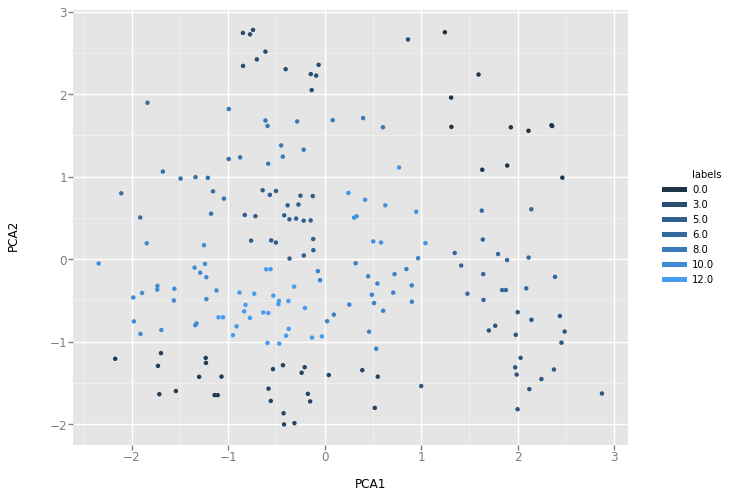

<ggplot: (-9223372029302744821)>


In [123]:
print(g)

In [124]:
fps.shape

(199, 2048)

In [125]:
merged_fps  = np.vstack([pat_fps, fps])
label = np.array(["patent"] * pat_fps.shape[0] + ["generate"] * fps.shape[0] )

In [126]:
pca = PCA(n_components=2)
x = pca.fit(merged_fps).transform(merged_fps)
af = AffinityPropagation().fit(x)

d = pd.DataFrame(x)
d.columns = ["PCA1", "PCA2"]
d["labels"] = pd.Series(label)
g = ggplot(aes(x="PCA1", y="PCA2", color="labels"), data=d) + geom_point() + xlab("PCA1") + ylab("PCA2")

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


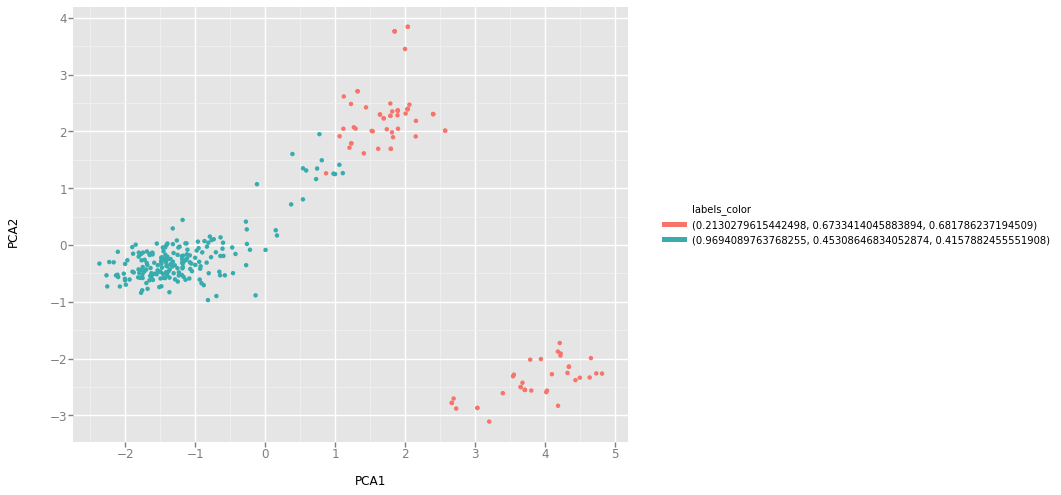

<ggplot: (-9223372036567736618)>


In [128]:
print(g)

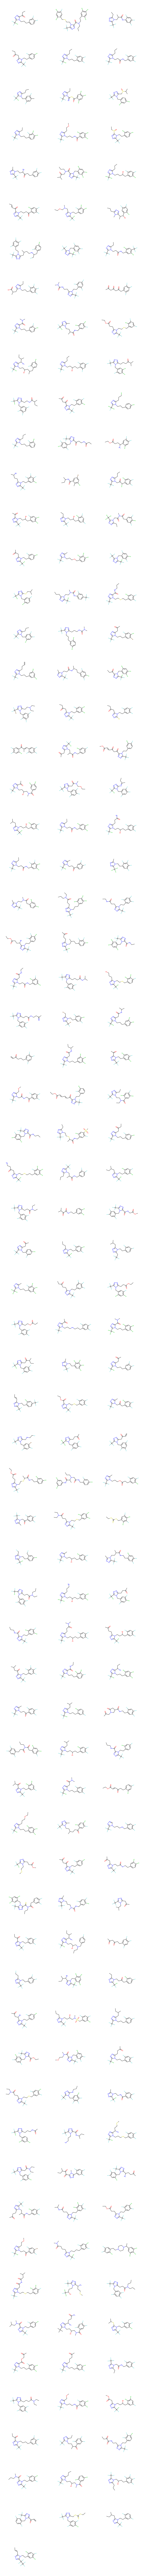

In [129]:
Draw.MolsToGridImage(mols, molsPerRow=3, subImgSize=(500,400))